# Code Alongs - Data Augmentation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets.mnist import load_data

(x_train, y_train), (x_test, y_test) = load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

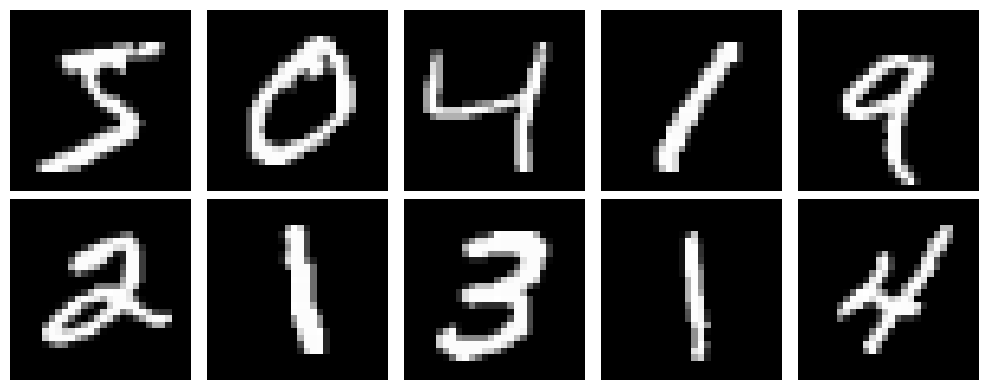

In [3]:
def plot_samples(data):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i], cmap = "gray")
        ax.axis("off")
    fig.tight_layout()

plot_samples(x_train)

In [4]:
#plot_samples(x_train[50000])

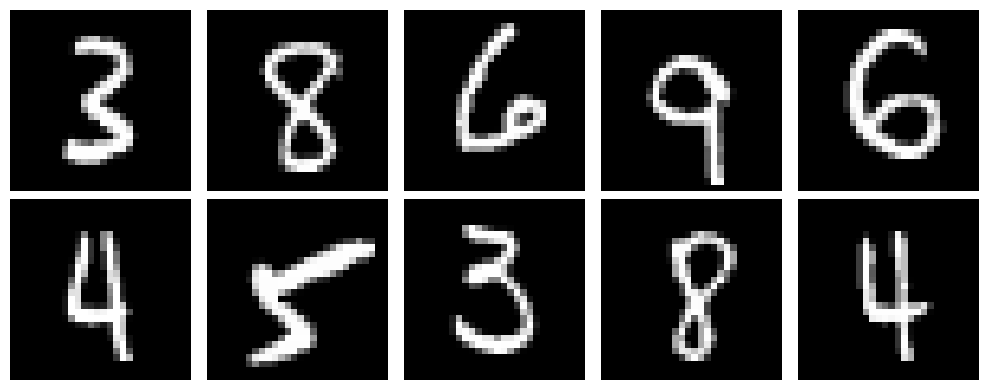

In [5]:
plot_samples(x_train[50000:50010])

In [6]:
X_train = x_train.astype("float32")/255
X_test = x_test.astype("float32")/255

X_train.min(), X_train.max()

(0.0, 1.0)

## Train|test split

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# we already have X_train: 60000 samples
# X_train_val: 50000 samples -> training part for validation and hyperparameter tuning
# X_val: 10000 samples -> validation used for hyperparameter tuning and validation loss curves
# train on tran_val and validate on val to hyperparameter tune, then when finished train on whole training data set
X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=1/6, random_state=42
)

X_train_val.shape, X_val.shape

((50000, 28, 28), (10000, 28, 28))

In [9]:
# we will use ImageDataGenerator to augment our data
# it requires rank 4 e.g. (50000, 28, 28, 3), (10000,28,28,1)
X_train_val[..., None].shape

(50000, 28, 28, 1)

In [10]:
X_train_val = X_train_val[..., None]
X_train = X_train[..., None]
X_val = X_val[..., None]
X_test = X_test[..., None]

X_train_val.shape

(50000, 28, 28, 1)

## Data augmentation

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rotation_range=90)

# batch size 32 - used for mini_batch gradient descent - which gives us  stochasticity in back propagration
# flow is used for regenerating images after it has been exhausted
# this is because we will train in many epochs
train_generator = train_image_generator.flow(X_train, y_train, batch_size=32)

train_generator

In [12]:
# 32 gray scaled images - first batch
train_generator[0][0].shape 

(32, 28, 28, 1)

In [13]:
train_generator[1][0].shape # 2nd batch

(32, 28, 28, 1)

In [14]:
train_generator[1][1].shape # labels for 2nd batch

(32,)

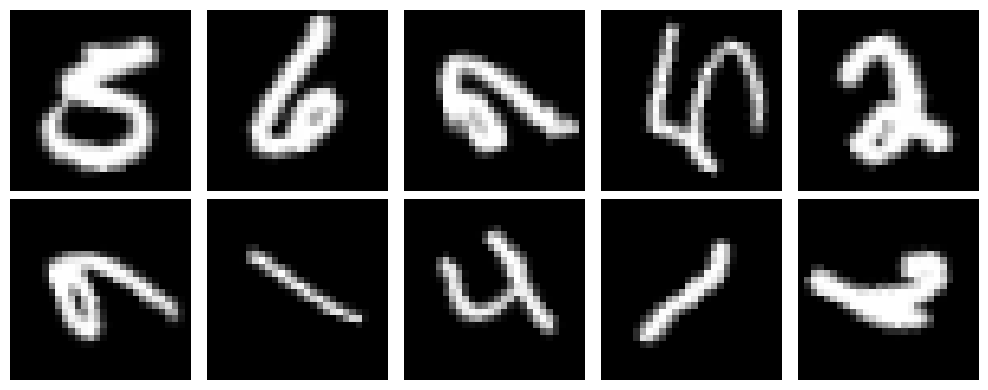

In [15]:
plot_samples(next(train_generator)[0])

### Make a good augmentation

In [16]:
train_image_generator = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=False,
    height_shift_range=0.2,
    width_shift_range=0.2,
)

# don't augment test data and validation data
test_image_generator = ImageDataGenerator()

train_generator = train_image_generator.flow(X_train, y_train, batch_size=32)
train_val_generator = train_image_generator.flow(X_train_val, y_train_val, batch_size=32)
val_generator = test_image_generator.flow(X_val, y_val, batch_size=32)

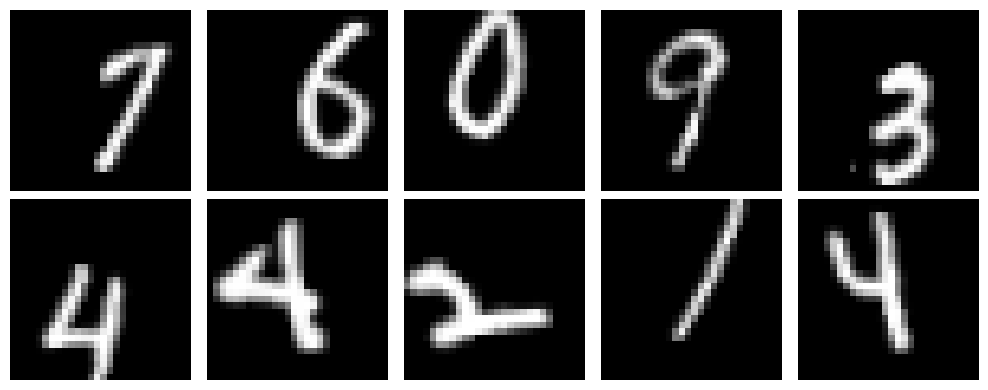

In [17]:
plot_samples(next(train_generator)[0])

# CNN Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def cnn_model(learning_rate=0.001, drop_rate=0.5, kernels=[32, 32]):
    adam = Adam(learning_rate=learning_rate)

    model = Sequential(name="CNN_model")

    for number_kernel in kernels:
        conv_layer = Conv2D(
            number_kernel,
            kernel_size=(3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=X_train.shape[1:],
        )

        model.add(conv_layer)
        # defaults to pool_size if None
        model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

    # MLP part
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(10, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["acc"]
    )

    return model

model = cnn_model(drop_rate=.5)

model.summary()

Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,194 (848.41 KB)

 Trainable params: 217,194 (848.41 KB)

 Non-trainable params: 0 (0.00 B)

## Training on Augmented Data

In [21]:
# number of steps for minibatch in one epoch 
steps_per_epoch = len(X_train_val)//32
validation_steps = len(X_val)//32

# number of batches to be ran in one epoch
steps_per_epoch, validation_steps

(1562, 312)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(
    monitor="val_acc", mode="max", patience=5, restore_best_weights=True
)

model.fit(
    train_val_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    callbacks=[early_stopper],
    validation_data = val_generator, # this will give us batches for validation
    validation_steps = validation_steps
)

Epoch 1/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - acc: 0.9061 - loss: 0.2963 - val_acc: 0.9740 - val_loss: 0.0849
Epoch 2/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 34us/step - acc: 0.9375 - loss: 0.1345 - val_acc: 1.0000 - val_loss: 0.0119
Epoch 3/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - acc: 0.9351 - loss: 0.2046 - val_acc: 0.9776 - val_loss: 0.0718
Epoch 4/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - acc: 0.9688 - loss: 0.0755 - val_acc: 1.0000 - val_loss: 0.0309
Epoch 5/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - acc: 0.9465 - loss: 0.1703 - val_acc: 0.9797 - val_loss: 0.0653
Epoch 6/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - acc: 0.9375 - loss: 0.0932 - val_acc: 1.0000 - val_loss: 0.0233
Epoch 7/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - acc: 0.9519 - loss: 0.1572 - val_acc: 0.9842 - val_loss: 0.0530


In [24]:
metrics = pd.DataFrame(model.history.history)
metrics

,acc,loss,val_acc,val_loss
0,0.916427,0.261968,0.973958,0.084863
1,0.937500,0.134439,1.000000,0.011908
2,0.939321,0.193047,0.977564,0.071795
3,0.968750,0.075487,1.000000,0.030905
4,0.947386,0.168065,0.979667,0.065330
5,0.937500,0.093126,1.000000,0.023301
6,0.951569,0.155398,0.984175,0.052987


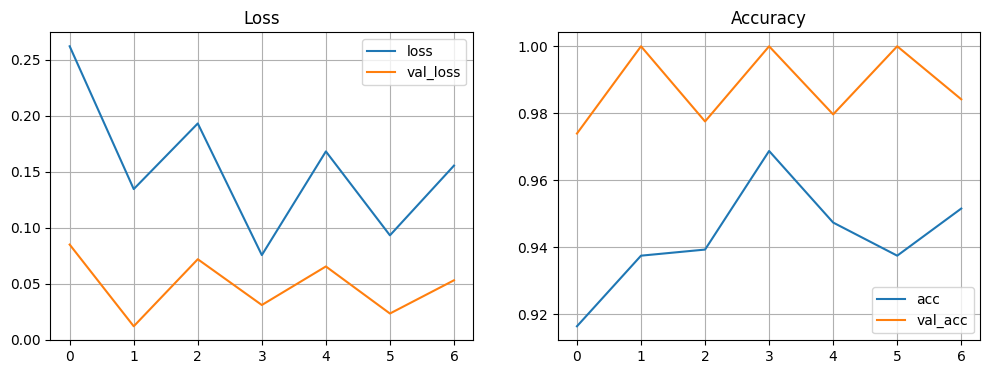

In [25]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True)

# harder to overfit
plot_metrics(metrics)

In [26]:
model = cnn_model()
# can recalculate steps_per_epoch to be 60000/32 instead of 50000/32
model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=10)

c:\Users\arthu\OneDrive\Documentos\VS\OPA - Semester 2\Python\AI2-Arthur-Lopez-OPA23\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
   8/1562 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - acc: 0.1001 - loss: 2.7187

c:\Users\arthu\OneDrive\Documentos\VS\OPA - Semester 2\Python\AI2-Arthur-Lopez-OPA23\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - acc: 0.6547 - loss: 1.0261
Epoch 2/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9060 - loss: 0.3012  
Epoch 3/10
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 4:04 156ms/step - acc: 0.7812 - loss: 0.3409

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - acc: 0.9178 - loss: 0.2568
Epoch 4/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.9362 - loss: 0.2051  
Epoch 5/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - acc: 0.9358 - loss: 0.1975
Epoch 6/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9435 - loss: 0.1768  
Epoch 7/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - acc: 0.9482 - loss: 0.1651
Epoch 8/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9510 - loss: 0.1520  
Epoch 9/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - acc: 0.9553 - loss: 0.1487
Epoch 10/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9591 - loss: 0.1300  


In [27]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


array([[3.5071637e-09, 3.1892793e-09, 1.2533028e-04, ..., 9.9987411e-01,
        5.8353983e-08, 2.2556189e-07],
       [1.6044320e-05, 5.1401435e-07, 9.9995291e-01, ..., 7.3987976e-06,
        1.3238186e-05, 4.3496505e-07],
       [1.1256509e-05, 9.9976879e-01, 2.0821125e-07, ..., 4.8041395e-05,
        5.7317052e-06, 5.7315851e-06],
       ...,
       [7.1482688e-08, 1.9414264e-07, 3.9970993e-07, ..., 1.3149696e-07,
        5.3424733e-06, 5.0755545e-05],
       [6.1706560e-06, 6.8000977e-10, 7.5255969e-07, ..., 1.0003445e-08,
        9.0151204e-04, 1.7887494e-05],
       [5.8103615e-05, 2.4286912e-08, 3.3789427e-05, ..., 3.2061644e-09,
        2.1252234e-05, 4.0786813e-06]], dtype=float32)

In [28]:
y_pred[0], y_test[0]

(array([3.5071637e-09, 3.1892793e-09, 1.2533028e-04, 9.7191773e-08,
        1.3186754e-07, 6.8965256e-10, 5.1088718e-13, 9.9987411e-01,
        5.8353983e-08, 2.2556189e-07], dtype=float32),
 7)

In [29]:
y_pred[50], y_test[50]

(array([3.9414061e-07, 3.1128014e-09, 2.0931562e-08, 1.3638532e-10,
        1.8070345e-08, 1.1609858e-07, 9.9999917e-01, 6.8711217e-11,
        3.1293933e-07, 3.8149924e-08], dtype=float32),
 6)

In [30]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.98      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.99      0.99       892
           6       0.98      0.99      0.99       958
           7       0.99      0.97      0.98      1028
           8       0.96      1.00      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



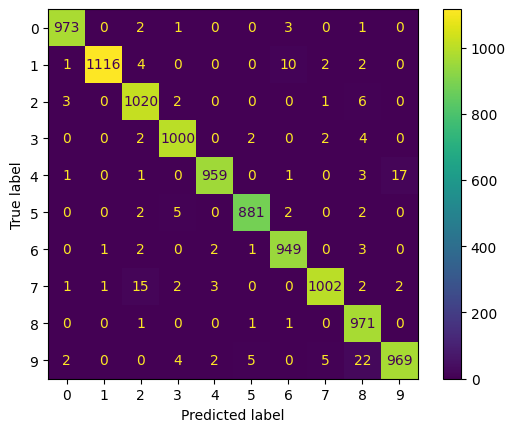

In [32]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()